# (Title to be decided)

*This is the file for the code of our group assignment. Under development.*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras_tuner.tuners import BayesianOptimization

# gpu acceleration, would cause an error when running without a cuda gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Set up a time calculation method for collecting time used during running the code:

In [2]:
# Variable for storing recorded timestamp
timer_record = 0

# Method for updating timer (setting the starting time)
def timer_start():
	global timer_record
	timer_record = time.time()

# Method for printing the time since last update
#
# the second num will be returned
def timer_read(print_result=True):
	second_passed = time.time() - timer_record
	if print_result:
		print(f"{second_passed:.3}s passed")
	return second_passed


## 1. Read Data from External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [3]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

# print one for checking
dataset_json[0]

10625 packets read


{'_index': 'packets-XXXX-XX-XX',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'pkt_comment': {'frame.comment': '13682128230572000042,china',
    'frame.comment_tree': {'_ws.expert': {'frame.comment.expert': '',
      '_ws.expert.message': '13682128230572000042,china',
      '_ws.expert.severity': '1048576',
      '_ws.expert.group': '184549376'}}},
   'frame': {'frame.interface_id': '0',
    'frame.interface_id_tree': {'frame.interface_name': 'unknown'},
    'frame.encap_type': '7',
    'frame.time': 'Not representable',
    'frame.offset_shift': '0.000000000',
    'frame.time_epoch': '-1460980371.753735000',
    'frame.time_delta': '0.000000000',
    'frame.time_delta_displayed': '0.000000000',
    'frame.time_relative': '0.000000000',
    'frame.number': '1',
    'frame.len': '58',
    'frame.cap_len': '58',
    'frame.marked': '0',
    'frame.ignored': '0',
    'frame.protocols': 'raw:ip:udp:dns',
    'frame.coloring_rule.name': 'UDP',
    'frame.coloring_rule.string': 

## 2. Data Preprocessing

### 2.1 Extract dataset labels and encoding

In [4]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

Labels include ['china' 'india' 'us']
(10625,)


### 2.2 Extract features

In [5]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


10.11.1.3
10.11.1.3
8.8.8.8
dns.google


### 2.3 Check data sanity and deal with missing fields

In [6]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

Source/dest IP not an IPv4 address:
[]
[]
Source/dest host not an IPv4 nor a domain:
[]
['no-data', 'no-data']

Indexes of rows with missing 'dst.host': [960 964]
Missing 'dst.host' filled


### 2.4 Bi-gram for similarity between IPs and domains

In [7]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


(10625, 1402)
(10625, 867)
(10625, 1629)
(10625, 1059)

(10625, 4957)


### 2.5 Normalization

In [8]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

(10625, 4957)


### 2.6 Principal Component Analysis (PCA)

In [9]:
# # PCA - check the 95% with figure
# pca = PCA()
# pca.fit(dataset_X)
# pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.axis([0, dataset_X.shape[1], 0, 1]) 
# plt.plot(pca_cumsum)
# plt.axhline(y=0.95,color='red')
# plt.xlabel("dimensions")
# plt.ylabel("explained variance")
# plt.grid(True)
# plt.show()

In [10]:
# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)

(10625, 650)


### 2.7 Dataset split

In [11]:
# Split the dataset into training set and testing set
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, random_state=12345)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7968, 650)
(7968,)
(2657, 650)
(2657,)


## 3. Model Training

### 3.1 Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(train_X, train_y)

LogisticRegression(max_iter=1000)

#### evaluating the performance for lr

In [13]:
# evaluating the lr performance using auc,f1, precision,recall, and accuracy
from sklearn.metrics import classification_report, \
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
y_pred = lr.predict(test_X)

f1 = f1_score(test_y, y_pred, average='macro')
recall = recall_score(test_y, y_pred,average='macro')
precision = precision_score(test_y, y_pred,average='macro')
acc = accuracy_score(test_y, y_pred)
print(classification_report(test_y, y_pred))
print(f'accuracy: {acc}, f1: {f1}, recall: {recall}, precision: {precision}')

              precision    recall  f1-score   support

       china       0.98      0.91      0.94       741
       india       0.81      0.98      0.89      1031
          us       0.96      0.80      0.87       885

    accuracy                           0.90      2657
   macro avg       0.92      0.89      0.90      2657
weighted avg       0.91      0.90      0.90      2657

accuracy: 0.8987579977418141, f1: 0.9016876006118091, recall: 0.8945181705103176, precision: 0.920636382619889


### 3.2 Support Vector Machine (SVM)

TODO

In [14]:
#For the linear kernel (kernel_type='linear') svm
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
SVM_linear = SVC(kernel='linear') 
SVM_linear.fit(train_X, train_y)
predict_results=SVM_linear.predict(test_X)
print(f"Accuracy on test set: {accuracy_score(predict_results, test_y):.4f}")

Accuracy on test set: 0.8965


In [15]:
#For the radial basis function kernel (kernel_type='rbf') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_rbf = SVC(kernel='rbf')  
SVM_rbf.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_rbf.score(test_X, test_y):.4f}")

Accuracy on test set: 0.8991


In [16]:
#For the polynomial kernel (kernel_type='poly') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_poly = SVC(kernel='poly') 
SVM_poly.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_poly.score(test_X, test_y):.4f}")

Accuracy on test set: 0.8995


In [17]:
#For the sigmoid function kernel (kernel_type='sigmoid') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_sig = SVC(C=1, kernel='sigmoid', gamma=10, decision_function_shape='ovr')
SVM_sig.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_sig.score(test_X, test_y):.4f}")

Accuracy on test set: 0.3801


### 3.3 neural network

Data proccess

In [18]:
keras.backend.clear_session()

temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y = pd.factorize(temp_train_y['country'], sort=True)[0]
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y, random_state=114514, test_size=0.3)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

test_y_nn = pd.DataFrame(test_y, columns=['country'])
test_y_nn = pd.factorize(test_y_nn['country'], sort=True)[0]

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)

(5577, 650)
(2391, 650)
(5577, 3)
(2391, 3)


Define model

In [19]:
def build_optimizer(hp):
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=1e-5)
    if optimizer == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    else:
        return keras.optimizers.SGD(learning_rate=lr, momentum=hp.Float('momentum', min_value=0, max_value=0.9, step=0.02))

def build_model(hp):
    model = keras.models.Sequential(keras.layers.InputLayer(input_shape=[train_X.shape[1]]))
    model.add(keras.layers.Dense(hp.Int('neurons1', min_value=1, max_value=300, step=5),
                                 activation=hp.Choice('actv1', ['relu', 'tanh', 'sigmoid']),
                                 kernel_initializer='he_normal'))
    if hp.Boolean('second_layer', True):
        model.add(keras.layers.Dropout(hp.Float('dropout1', min_value=0, max_value=0.3, step=0.02)))
        model.add(keras.layers.Dense(hp.Int('neurons2', min_value=1, max_value=300, step=5),
                                     activation=hp.Choice('actv2', ['relu', 'tanh', 'sigmoid']),
                                     kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(3, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=build_optimizer(hp),
                  metrics=['accuracy'])
    return model

Bayesion optimization

In [20]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    project_name='neural_network_optimize'
)

tuner.search(x=train_X_nn, y=train_y_nn, epochs=35, validation_data=(validate_X, validate_y))

best_hps = tuner.get_best_hyperparameters()[0]
print(f'Best hyperparameters: {best_hps.values}')


Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.8766206502914429

Best val_accuracy So Far: 0.8822668194770813
Total elapsed time: 00h 04m 49s
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'neurons1': 281, 'actv1': 'relu', 'second_layer': False, 'dropout1': 0.02, 'neurons2': 131, 'actv2': 'relu', 'optimizer': 'adam', 'learning_rate': 6e-05}


Model Trainning

In [21]:
optimized_model = build_model(best_hps)
history = optimized_model.fit(train_X_nn, train_y_nn, epochs=35,
                     validation_data=(validate_X, validate_y))
optimized_model.summary()

Epoch 1/35
175/175 [==============================] - 1s 3ms/step - loss: 1.0565 - accuracy: 0.4938 - val_loss: 1.0012 - val_accuracy: 0.6512
Epoch 2/35
175/175 [==============================] - 0s 2ms/step - loss: 0.9461 - accuracy: 0.7443 - val_loss: 0.9007 - val_accuracy: 0.7867
Epoch 3/35
175/175 [==============================] - 0s 2ms/step - loss: 0.8471 - accuracy: 0.7902 - val_loss: 0.8080 - val_accuracy: 0.8147
Epoch 4/35
175/175 [==============================] - 0s 2ms/step - loss: 0.7555 - accuracy: 0.8150 - val_loss: 0.7228 - val_accuracy: 0.8260
Epoch 5/35
175/175 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.8261 - val_loss: 0.6464 - val_accuracy: 0.8302
Epoch 6/35
175/175 [==============================] - 0s 2ms/step - loss: 0.5995 - accuracy: 0.8436 - val_loss: 0.5810 - val_accuracy: 0.8373
Epoch 7/35
175/175 [==============================] - 0s 2ms/step - loss: 0.5380 - accuracy: 0.8540 - val_loss: 0.5266 - val_accuracy: 0.8415
Epoch 

Output

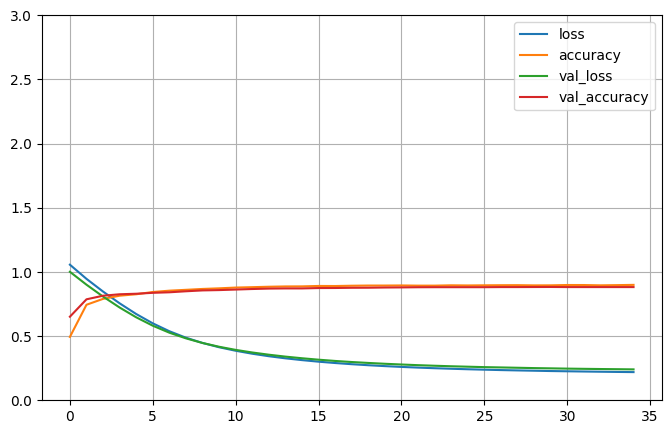

84/84 [==============================] - 0s 1ms/step
Accuracy on test set: 89.73%


In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

y_pred = optimized_model.predict(test_X)
prediction = np.argmax(y_pred, axis=1)
count=0
for i,j in zip(prediction, test_y_nn):
  if i==j:
    count+=1
print(f'Accuracy on test set: {count*100/test_y_nn.shape[0]:.2f}%')

## 4. Model Testing and Comparison

TODO